In [1]:
import os
import json
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import AgglomerativeClustering
from sklearn.impute import SimpleImputer
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import json
import pandas as pd
from langchain_ollama import OllamaEmbeddings

In [37]:
def calculate_frequency(tags):
    tag_freq = {}
    for tag in tags:
        tag_freq[tag] = tag_freq.get(tag, 0) + 1
    return tag_freq

def generate_tag_cloud(tags):
    tag_freq = calculate_frequency(tags)
    wordcloud = WordCloud(width=800, height=400, background_color ='white').generate_from_frequencies(tag_freq)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

In [50]:
class Clusterizer:
    def __init__(self, model="snowflake-arctic-embed:22m", distance_threshold=0.5):
        """
        Initialize the OllamaClusterizer with Ollama embeddings and clustering parameters.
        :param model: Ollama model to generate embeddings.
        :param distance_threshold: Threshold for clustering distance (lower = tighter clusters).
        """
        self.embeddings = OllamaEmbeddings(model=model)
        self.distance_threshold = distance_threshold

    def _compute_embeddings(self, phrases):
        """
        Compute embeddings for a list of phrases using Ollama.
        :param phrases: List of phrases to embed.
        :return: List of embeddings for the phrases.
        """
        return self.embeddings.embed_documents(phrases)

    def clusterize(self, phrases):
        """
        Cluster phrases based on their embeddings using agglomerative clustering.
        :param phrases: List of phrases to be clustered.
        :return: Dictionary with cluster labels and corresponding phrases.
        """
        embeddings = self._compute_embeddings(phrases)

        # Perform agglomerative clustering
        clustering_model = AgglomerativeClustering(
            linkage='average',
            distance_threshold=self.distance_threshold,
            n_clusters=None
        )
        labels = clustering_model.fit_predict(embeddings)

        # Group phrases by their cluster labels
        clusters = {}
        for label, phrase in zip(labels, phrases):
            clusters.setdefault(label, []).append(phrase)

        return clusters
    
class RoleGroupProcessor(Clusterizer):
    def __init__(self, folder_path, model="snowflake-arctic-embed:22m", distance_threshold=0.3):
        """
        Initialize with folder path and inherit clustering functionality.
        :param folder_path: Path to the folder containing JSON files.
        :param model: Ollama model to generate embeddings.
        :param distance_threshold: Threshold for clustering distance (lower = tighter clusters).
        """
        super().__init__(model=model, distance_threshold=distance_threshold)
        self.folder_path = folder_path

    def load_json(self, file_path):
        """
        Load the JSON data from the file at file_path.
        :param file_path: Path to the JSON file.
        :return: Loaded JSON data.
        """
        with open(file_path, 'r') as file:
            return json.load(file)

    def extract_roles(self):
        """
        Extract roles (actor, victim, neither) from the JSON files in the folder.
        :return: Dictionary with roles and corresponding phrases.
        """
        files = os.listdir(self.folder_path)
        roles = {
            "actor": [],
            "victim": [],
            "neither": []
        }
        sources = {
            "actor": [],
            "victim": [],
            "neither": []
        }

        for file in files:
            if file.endswith(".json"):
                data = self.load_json(os.path.join(self.folder_path, file))
                if data.get('analysis') and data['analysis'].get('Q3'):
                    for item in data['analysis']['Q3']:
                        category = item.get('category', "").lower()
                        if 'actor' in category:
                            roles['actor'].append(item.get('name'))
                            sources['actor'].append(file)
                        elif 'victim' in category:
                            roles['victim'].append(item.get('name'))
                            sources['victim'].append(file)
                        else:
                            roles['neither'].append(item.get('name'))
                            sources['neither'].append(file)

        return roles, sources

    def replace_roles_with_representative(self, roles, representative_clusters):
        """
        Replace all the actor/victim/neither names with their respective representative cluster value if
        the cluster contains more than 2 items.
        If the cluster has 2 or fewer items, leave the phrase unchanged.
        
        :param roles: Dictionary of roles (actor, victim, etc.) with their names.
        :param representative_clusters: Dictionary of cluster labels and corresponding phrases.
        :return: Updated roles dictionary with all names replaced by their cluster representative (if applicable).
        """
        updated_roles = {role: [] for role in roles}

        for subrole in roles.keys():
            for phrase in roles[subrole]:
                # Find which bucket (cluster) the phrase belongs to
                for label, bucket in representative_clusters.items():
                    if phrase in bucket:
                        # If the bucket has more than 2 items, replace with the representative (first item in the bucket)
                        if len(bucket) > 2:
                            updated_roles[subrole].append(bucket[0])
                        else:
                            updated_roles[subrole].append(phrase)
                        break  

        return updated_roles

    def process(self):
        """
        Complete process for extracting roles, clustering, and replacing with representatives.
        :return: Dictionary with roles and their updated phrases.
        """
        # Extract roles from the folder
        roles, sources = self.extract_roles()

        # Cluster the phrases
        all_phrases = roles['actor'] + roles['victim'] + roles['neither']
        representative_clusters = self.clusterize(all_phrases)

        # Replace roles with the representative phrases
        updated_roles = self.replace_roles_with_representative(roles, representative_clusters)

        return updated_roles, sources

class ServeVisualization:
    def __init__(self):
        self.folder_path = ''
        self.roles, self.sources = self._preprocess()
    
    def _preprocess(self):
        processor = RoleGroupProcessor(self.folder_path)
        return processor.process()
    
    def generate_plots(self):
       pass 
        


In [51]:
processor = RoleGroupProcessor(folder_path="/mnt/hdd/RA/Codes/stable/news_anlyzed_gpt4o_fixed")
roles, sources = processor.process()

For actor


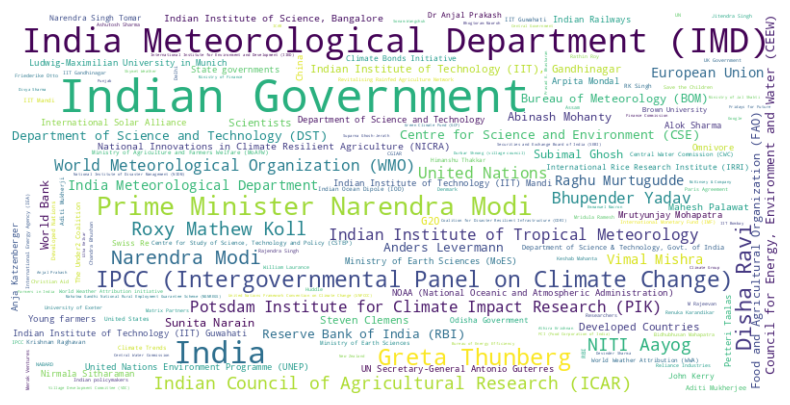

For victim


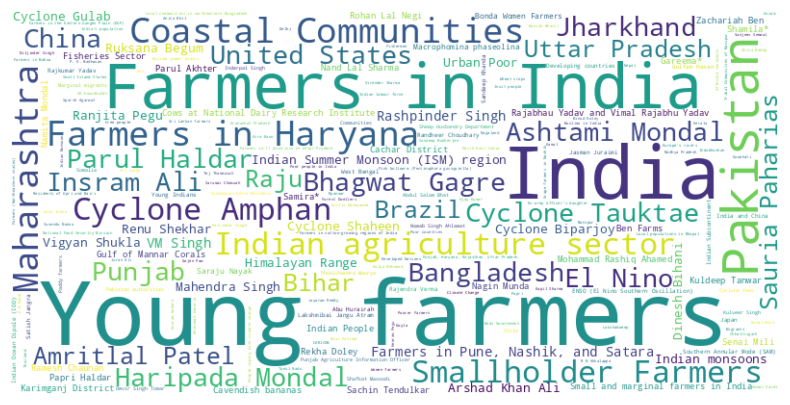

For neither


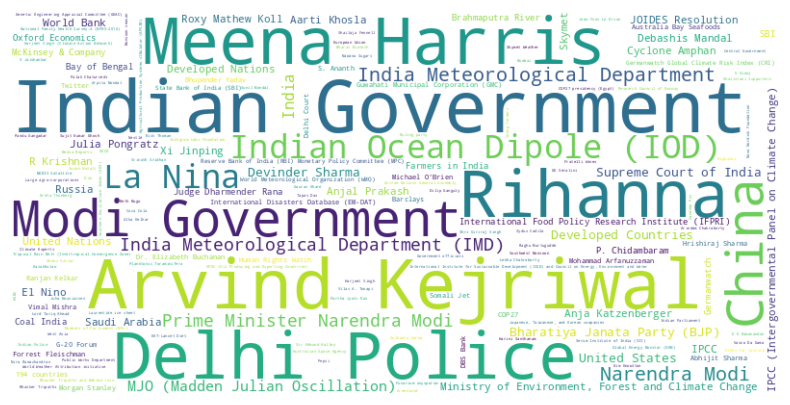

In [54]:
for subrole in roles.keys():
    print(f"For {subrole}")
    generate_tag_cloud(roles[subrole])


In [ ]:
from gliner import GLiNER

# Initialize GLiNER with the base model
model = GLiNER.from_pretrained("urchade/gliner_medium-v2.1")

# Sample text for entity prediction
text = "\n".join(set(roles['actor']))

# Labels for entity prediction
# Most GLiNER models should work best when entity types are in lower case or title case
labels = ["Person", "Location", "Organization", "Climate", "MISC"]

# Perform entity prediction
entities = model.predict_entities('NABARD', labels, threshold=0.5)

# Display predicted entities and their labels
for entity in entities:
    print(entity["text"], "=>", entity["label"])

In [2]:
dir_path = "/mnt/hdd/RA/Codes/stable/news_anlyzed_gpt4o_fixed"

from glob import glob
import json

prompt = ""
files = glob(f"{dir_path}/*.json")

for file in files:
    with open(file, 'r') as f:
        data = json.load(f)
        prompt += "\n"
        prompt += f"Filename: {file}\n"
        prompt += str(data['analysis']['Q2']) + "\n" + str(data['analysis']['Q3'])





{'Q1': 'Agriculture', 'Q2': [{'name': 'Bioprime Agrisolutions', 'role': 'Developed environment-friendly bio-molecules to make crops more climate resilient.'}, {'name': 'Renuka Karandikar', 'role': 'CEO of Bioprime Agrisolutions, explained the benefits of bio-molecules in enhancing crop growth even in adverse weather.'}, {'name': 'Farmers', 'role': 'Implement the bio-molecules on their crops, especially those cultivating export-quality fruits like grapes and pomegranate.'}, {'name': 'Biotechnology Industry Research Assistance Council (BIRAC)', 'role': 'Awarded Rs 1 crore under LEAP funds to Bioprime Agrisolutions.'}, {'name': 'Atal Innovation Mission', 'role': 'Granted funds to Bioprime Agrisolutions under the Atal New India Challenge for climate resilient agriculture.'}], 'Q3': [{'name': 'Bioprime Agrisolutions', 'category': 'Actor contributing to alleviate the impact of climate change'}, {'name': 'Renuka Karandikar', 'category': 'Actor contributing to alleviate the impact of climate c

'1.json'